In [1]:
from weisfeiler_lehman_graph_kernel import Weisfeiler_Lehman
import os
import numpy as np
import scipy.io as sio
import threading
import matplotlib.pyplot as plt
import pprint
from sklearn import svm, manifold
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.svm import SVC


import sys

if not sys.warnoptions:
    # To avoid massive warnings from different configuration of neighbours
    # and components during the tests.
    import warnings
    warnings.simplefilter("ignore")



PPI = "./PPI"
SHOCK = "./SHOCK"

PPI_filenames = os.listdir(PPI)
SHOCK_filenames = os.listdir(SHOCK)

PPI_dataset = [
    np.genfromtxt(PPI + "/" + filename, delimiter=",") for filename in PPI_filenames
]

SHOCK_dataset = [
    np.genfromtxt(SHOCK + "/" + filename, delimiter=",") for filename in SHOCK_filenames
]

labels_PPI = PPI_dataset[-1]
labels_SHOCK = SHOCK_dataset[-1]

matrices_adjacency_PPI = PPI_dataset[:-1].copy()
matrices_adjacency_SHOCK = SHOCK_dataset[:-1].copy()

del PPI_dataset, SHOCK_dataset



wl_PPI = Weisfeiler_Lehman(matrices_adjacency_PPI,4)
wl_SHOCK = Weisfeiler_Lehman(matrices_adjacency_SHOCK, 4)

t1 = threading.Thread(name="PPI", target=wl_PPI.weisfeiler_lehman_algorithm)
t2 = threading.Thread(name="SHOCK", target=wl_SHOCK.weisfeiler_lehman_algorithm)



# import time as time
# start = time()
threads = [t1, t2]
for t in threads:
    t.start()
for t in threads:
    t.join()
# print("MULTITHREADING TIME: " + str(time()-start))

# start = time()
# wl_PPI.weisfeiler_lehman_algorithm()
# wl_SHOCK.weisfeiler_lehman_algorithm()
# print("SINGLE PROCESS TIME: " + str(time()-start))


similarity_matrices = [wl_PPI.pairwise_similarity_matrix, wl_SHOCK.pairwise_similarity_matrix]
labels = [labels_PPI, labels_SHOCK]
datasets_names = ['PPI', 'SHOCK'] #da capire cosa serve 


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


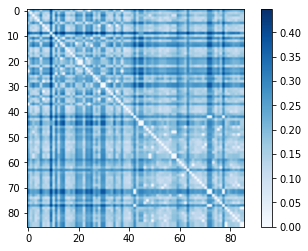

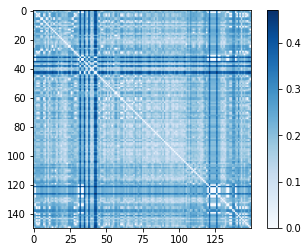

In [2]:
dms = []
for i in range(len(similarity_matrices)):
    pd = pairwise_distances(similarity_matrices[i], metric='euclidean')
    dms.append(pd)
    plt.imshow(pd, cmap='Blues')
    plt.colorbar()
    plt.show()

### SVMs without manifold learning step

In [3]:
kfold = StratifiedKFold(n_splits=10, shuffle=True) 
clf = svm.SVC(kernel="linear")
linear_svm_scores = [
    [
        (cv_score := cross_val_score(clf, dms[i], labels[i], cv=kfold)).min(),
        cv_score.mean(),
        cv_score.max(),
        cv_score.std(),
        datasets_names[i] + " with linear kernel" 
    ]
    for i in range(len(dms))
]
# for i in range(len(dms)):
#     cv_score = cross_val_score(clf, dms[i], labels[i], cv = kfold)
#     print(f'DATASET: {datasets_names[i]}\nMinimum: {np.min(cv_score)}\nMean: {np.mean(cv_score)}\nMax: {np.max(cv_score)}')
#     print(f'Standard deviation: {np.std(cv_score)}\n')

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(linear_svm_scores)

[ [ 0.625,
    0.7097222222222223,
    0.875,
    0.07744223255250361,
    'PPI with linear kernel'],
  [ 0.13333333333333333,
    0.29333333333333333,
    0.4666666666666667,
    0.09521904571390467,
    'SHOCK with linear kernel']]


### SVMs with Isomap manifold learning

In [4]:
def parallel_iso_evaluation_ppi(act_neighbor):
    return [
        [
            (cv_score := cross_val_score(
                            estimator=clf,
                            X=manifold.Isomap(
                                n_neighbors=act_neighbor, n_components= n_components
                            ).fit_transform(dms[0]),
                            y=labels[0],
                            cv=kfold,
                            n_jobs = -1
                        )).min(),                       # Minimum -0
            cv_score.mean(),                            # Avarage -1
            cv_score.max(),                             # Maximum -2
            cv_score.std(),                             # Standard_Deviation -3
            datasets_names[0] + ": " + "ISO",                    # Dataset -4
            act_neighbor,                                # Neighbours -5
            n_components                                # Components -6
        ]
        
        for n_components in range(2, 15)
    ]

def parallel_iso_evaluation_shock(act_neighbor):
    return [
        [
            (cv_score := cross_val_score(
                            estimator=clf,
                            X=manifold.Isomap(
                                n_neighbors=act_neighbor, n_components= n_components
                            ).fit_transform(dms[1]),
                            y=labels[1],
                            cv=kfold,
                            n_jobs = -1
                        )).min(),                       # Minimum -0
            cv_score.mean(),                            # Avarage -1
            cv_score.max(),                             # Maximum -2
            cv_score.std(),                             # Standard_Deviation -3
            datasets_names[1] + ": " + "ISO",                          # Dataset -4
            act_neighbor,                               # Neighbours -5
            n_components                                # Components -6
        ]
        
        for n_components in range(2, 15)
    ]
    
def parallel_lle_evaluation_ppi(act_neighbor):
    return [
        [
            (cv_score := cross_val_score(
                            estimator=clf,
                            X=manifold.LocallyLinearEmbedding(
                                n_neighbors=act_neighbor, n_components= n_components
                            ).fit_transform(dms[0]),
                            y=labels[0],
                            cv=kfold,
                            n_jobs = -1
                        )).min(),                       # Minimum -0
            cv_score.mean(),                            # Avarage -1
            cv_score.max(),                             # Maximum -2
            cv_score.std(),                             # Standard_Deviation -3
            datasets_names[0] + ": " + "LLE",                    # Dataset -4
            act_neighbor,                                # Neighbours -5
            n_components                                # Components -6
        ]
        
        for n_components in range(2, 15)
    ]

def parallel_lle_evaluation_shock(act_neighbor):
    return [
        [
            (cv_score := cross_val_score(
                            estimator=clf,
                            X=manifold.LocallyLinearEmbedding(
                                n_neighbors=act_neighbor, n_components= n_components
                            ).fit_transform(dms[1]),
                            y=labels[1],
                            cv=kfold,
                            n_jobs = -1
                        )).min(),                       # Minimum -0
            cv_score.mean(),                            # Avarage -1
            cv_score.max(),                             # Maximum -2
            cv_score.std(),                             # Standard_Deviation -3
            datasets_names[1] + ": " + "LLE",                          # Dataset -4
            act_neighbor,                               # Neighbours -5
            n_components                                # Components -6
        ]
        for n_components in range(2, 15)
    ]

### SVMs with LLE manifold learning

In [5]:
import multiprocessing
ppi_iso_results = []
shock_iso_results = []
ppi_lle_results = []
shock_lle_results = []

with multiprocessing.Pool() as pool:
    ppi_iso_results = pool.map(parallel_iso_evaluation_ppi, range(2, 25))
    shock_iso_results = pool.map(parallel_iso_evaluation_shock, range(2, 25))
    ppi_lle_results = pool.map(parallel_lle_evaluation_ppi, range(2, 25))
    shock_lle_results = pool.map(parallel_lle_evaluation_shock, range(2, 25))

ppi_iso_results = ppi_iso_results[0]
shock_iso_results = shock_iso_results[0]
ppi_lle_results = ppi_lle_results[0]
shock_lle_results = shock_lle_results[0]


In [6]:
# pp = pprint.PrettyPrinter(indent=2)
# pp.pprint(ppi_iso_results)

In [7]:
import pandas as pd

def print_accuracy_table(dataset):
    # pp.pprint(dataset)
    score_dataset_names = []
    score_min = []
    score_max = []
    score_avg = []
    score_std = []
    score_neigh = []
    score_comps = []

    for score in dataset:
        score_dataset_names.append(score[4])
        score_min.append(score[0])
        score_max.append(score[2])
        score_avg.append(score[1])
        score_std.append(score[3])
        score_neigh.append(score[5])
        score_comps.append(score[6])

    global dataset_table
    dataset_table = pd.DataFrame(
        {
            "Minimum Accuracy": score_min,
            "Average Accuracy": score_avg,
            "Maximum Accuracy": score_max,
            "Standard deviation of Accuracy": score_std,
            "# Neighbours": score_neigh,
            "# Components": score_comps,
        },
        index = score_dataset_names
    )
    dataset_table.index.name = 'Dataset'
    dataset_table.sort_values(by=['Average Accuracy'], ascending=False)
    return dataset_table

print_accuracy_table(ppi_iso_results)

,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Standard deviation of Accuracy,# Neighbours,# Components
Dataset,,,,,,
PPI: ISO,0.333333,0.593056,0.777778,0.156649,2,2
PPI: ISO,0.625000,0.765278,0.888889,0.108200,2,3
PPI: ISO,0.666667,0.769444,1.000000,0.108866,2,4
PPI: ISO,0.625000,0.765278,1.000000,0.092640,2,5
PPI: ISO,0.555556,0.768056,1.000000,0.116211,2,6
PPI: ISO,0.444444,0.772222,1.000000,0.165179,2,7
PPI: ISO,0.625000,0.762500,1.000000,0.124451,2,8
PPI: ISO,0.555556,0.769444,0.888889,0.111838,2,9
PPI: ISO,0.375000,0.740278,1.000000,0.184994,2,10


(Sembra che con ISOMAP su PPI si ottenga buoni risultati solo con 2 neighbours)

In [8]:
print_accuracy_table(ppi_lle_results)

,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Standard deviation of Accuracy,# Neighbours,# Components
Dataset,,,,,,
PPI: LLE,0.500000,0.544444,0.666667,0.048432,2,2
PPI: LLE,0.500000,0.533333,0.555556,0.027217,2,3
PPI: LLE,0.500000,0.533333,0.555556,0.027217,2,4
PPI: LLE,0.500000,0.566667,0.666667,0.069389,2,5
PPI: LLE,0.500000,0.613889,0.888889,0.108440,2,6
PPI: LLE,0.500000,0.594444,0.750000,0.069110,2,7
PPI: LLE,0.500000,0.650000,0.777778,0.077529,2,8
PPI: LLE,0.500000,0.613889,0.777778,0.096385,2,9
PPI: LLE,0.555556,0.756944,0.888889,0.090278,2,10


In [9]:
print_accuracy_table(shock_iso_results)

,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Standard deviation of Accuracy,# Neighbours,# Components
Dataset,,,,,,
SHOCK: ISO,0.000000,0.220000,0.400000,0.099107,2,2
SHOCK: ISO,0.133333,0.233333,0.333333,0.074536,2,3
SHOCK: ISO,0.066667,0.306667,0.466667,0.120000,2,4
SHOCK: ISO,0.133333,0.286667,0.400000,0.103494,2,5
SHOCK: ISO,0.133333,0.300000,0.466667,0.085635,2,6
SHOCK: ISO,0.200000,0.360000,0.466667,0.112349,2,7
SHOCK: ISO,0.133333,0.360000,0.600000,0.130639,2,8
SHOCK: ISO,0.266667,0.373333,0.533333,0.090431,2,9
SHOCK: ISO,0.200000,0.353333,0.533333,0.089691,2,10


In [10]:
print_accuracy_table(shock_lle_results)

,Minimum Accuracy,Average Accuracy,Maximum Accuracy,Standard deviation of Accuracy,# Neighbours,# Components
Dataset,,,,,,
SHOCK: LLE,0.000000,0.100000,0.200000,0.061464,2,2
SHOCK: LLE,0.000000,0.120000,0.200000,0.058119,2,3
SHOCK: LLE,0.066667,0.120000,0.200000,0.040000,2,4
SHOCK: LLE,0.000000,0.126667,0.266667,0.075719,2,5
SHOCK: LLE,0.000000,0.100000,0.200000,0.061464,2,6
SHOCK: LLE,0.000000,0.100000,0.133333,0.044721,2,7
SHOCK: LLE,0.000000,0.153333,0.333333,0.084591,2,8
SHOCK: LLE,0.000000,0.106667,0.266667,0.085375,2,9
SHOCK: LLE,0.066667,0.113333,0.200000,0.052068,2,10


We can now give a gaphical look to how the several configurations are behaving:

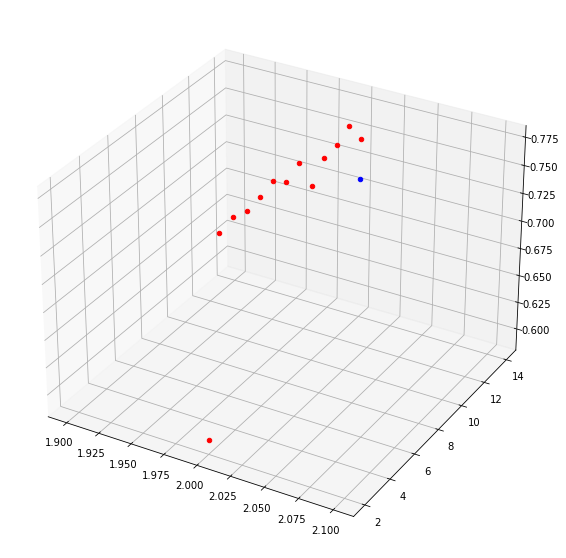

In [11]:
# print_accuracy_table(shock_lle_results).plot.area(stacked=False)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
for score in ppi_iso_results:
    ax.scatter(score[5], score[6], score[1], color = "red")
ax.scatter(ppi_iso_results[-1][5], ppi_iso_results[-1][6], linear_svm_scores[0][1], color = "blue")
